## Filter the CMIP5 catalog
Here, we filter the catalog of CMIP5 data to export a list of only the files we need for our analysis.
We assume we work on a machine of the DKRZ.
Alternatively, the data can be downloaded from the web.

In [11]:
import intake
import matplotlib.pyplot as plt
import numpy as np
from src import *

## 1. Filter the catalog
First, we need to filter the CMIP catalog to get only the files we need. We will use the `intake-esm` library to do this.

We can either use one of the intake catalogs provided by DKRZ or create our own. 

In [12]:
dkrz_catalog = intake.open_catalog(["https://dkrz.de/s/intake"])
list(dkrz_catalog)

['dkrz_cmip5_archive',
 'dkrz_cmip5_disk',
 'dkrz_cmip6_cloud',
 'dkrz_cmip6_disk',
 'dkrz_cordex_disk',
 'dkrz_dyamond-winter_disk',
 'dkrz_eerie',
 'dkrz_era5_disk',
 'dkrz_monsoon_disk',
 'dkrz_mpige_disk',
 'dkrz_nextgems_disk',
 'dkrz_palmod2_disk']

In [13]:
col = dkrz_catalog['dkrz_cmip5_disk']
col

,unique
project,1
product_id,3
institute,29
model,63
experiment,106
frequency,8
modeling_realm,7
mip_table,22
ensemble_member,341
version,549


### Filter the catalog with a custom query
Now we filter the catalog with a custom query. We want to get all entries that match the following criteria:
- variable: `tas`
- frequency: `month`
- experiment: must have simulated all of the following experiments: `historical`, `historicalGHG`, `historicalNat`, `piControl`

The `require_all_on='model'` argument ensures that only models are selected which meet all the search criteria.


In [14]:
query = dict(experiment=['historical','historicalNat','historicalGHG', 'piControl'],
             variable='tas',
             frequency=['mon'],
             require_all_on='model',
            #  ensemble_member=re.compile(r"r\d+i1p1"),   # this is not implemented currently
            )
cat = col.search(**query)
cat.df.ensemble_member.unique()

array(['r1i1p1', 'r2i1p1', 'r3i1p1', 'r1i2p1', 'r1i2p2', 'r4i1p1',
       'r5i1p1', 'r6i1p1', 'r10i1p1', 'r7i1p1', 'r8i1p1', 'r9i1p1',
       'r1i1p2', 'r1i1p3', 'r2i1p2', 'r2i1p3', 'r3i1p2', 'r3i1p3',
       'r4i1p2', 'r4i1p3', 'r5i1p2', 'r5i1p3', 'r6i1p2', 'r6i1p3',
       'r1i1p121', 'r1i1p122', 'r1i1p123', 'r1i1p124', 'r1i1p125',
       'r1i1p126', 'r1i1p127', 'r1i1p128', 'r1i1p141', 'r1i1p142'],
      dtype=object)

However, we see that there are quite some members with `p` numbers other than 1.
We want to exclude them. Therefore, we filter accordingly:

In [15]:
r1_members = [i for i in cat.df['ensemble_member'].unique() if i.endswith('i1p1')]
experiment_ids = ['historical','historicalNat','historicalGHG', 'piControl']

cat = cat.search(ensemble_member=r1_members)
cat = cat.search(experiment=experiment_ids, require_all_on='model')
cat


,unique
project,1
product_id,1
institute,17
model,19
experiment,4
frequency,1
modeling_realm,1
mip_table,1
ensemble_member,10
version,64


In [16]:
df_overview = cat.df.groupby(['model', 'experiment']).ensemble_member.aggregate('nunique').unstack()
models = df_overview.dropna(axis=0).index
df_overview

experiment,historical,historicalGHG,historicalNat,piControl
model,,,,
ACCESS1-3,3,3,3,1
BNU-ESM,1,1,1,1
CCSM4,6,3,4,3
CESM1-CAM5,3,3,3,1
CNRM-CM5,10,6,6,1
CSIRO-Mk3-6-0,10,10,10,1
CanESM2,5,5,5,1
FGOALS-g2,5,1,3,1
GFDL-CM3,5,3,3,1


In [17]:
def highlight_nonNaN(val):
    """Helper function to highlight all non-NaN values."""
    color = 'rgba(0,255,50,.2)' if not np.isnan(val) else ''
    return 'background-color: {}'.format(color)

d_ = cat.df.groupby(['model', 'experiment'])['ensemble_member'].aggregate('nunique').unstack()

d_ = d_[sorted(d_.columns, key=str.lower)]

display(d_
        .style
        .map(highlight_nonNaN)
        .set_caption('Number of unique member_ids per model and experiment')
        .format(None, na_rep="", precision=0)
        .set_properties(**{'border-color': 'grey', 'border-style' :'dotted', 'border-width':'thin'})
)

print('\nSUMMARY:')
print('='*8)
print(d_.sum())

experiment,historical,historicalGHG,historicalNat,piControl
model,,,,
ACCESS1-3,3,3,3,1
BNU-ESM,1,1,1,1
CCSM4,6,3,4,3
CESM1-CAM5,3,3,3,1
CNRM-CM5,10,6,6,1
CSIRO-Mk3-6-0,10,10,10,1
CanESM2,5,5,5,1
FGOALS-g2,5,1,3,1
GFDL-CM3,5,3,3,1



SUMMARY:
experiment
historical       85
historicalGHG    60
historicalNat    63
piControl        21
dtype: int64


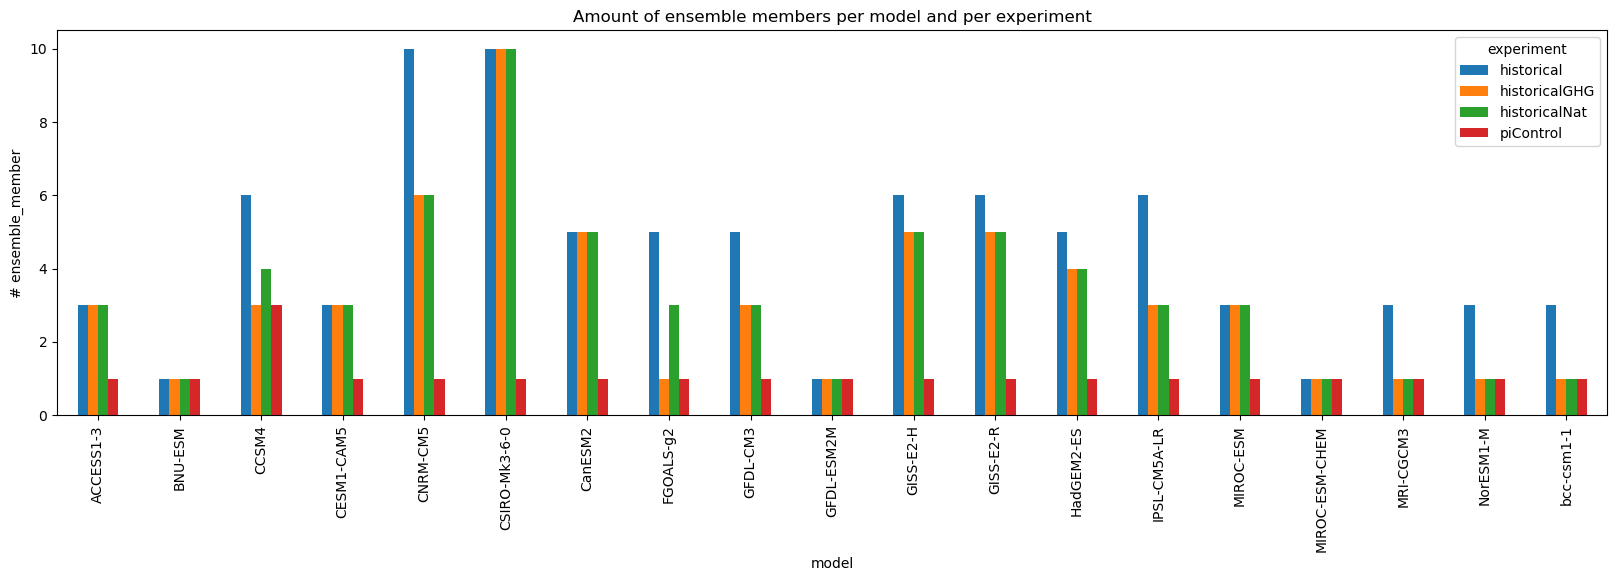

In [9]:
   
d_.plot(rot=90, figsize=(20,5), kind='bar')
plt.ylabel('# ensemble_member')
plt.title("Amount of ensemble members per model and per experiment");

### Save catalog subset to csv file

In [21]:
for experiment_id in cat.unique()['experiment']:
    cat_ = cat.search(experiment=experiment_id)
    output_file = DATA_DIR/f'catalog-filter-{experiment_id}.csv'
    cat_.df.to_csv(output_file, index=False)
    print(f"Saved to {output_file.relative_to(BASE_DIR)}")

Saved to data/catalog-filter-historical.csv
Saved to data/catalog-filter-historicalGHG.csv
Saved to data/catalog-filter-historicalNat.csv
Saved to data/catalog-filter-piControl.csv
